## we would like to achieve an Enhanced Fourier Transform using a wavelet packet decomposition


S_N_R : -30.11
MSE: 1028.98


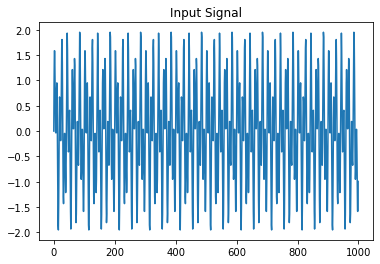

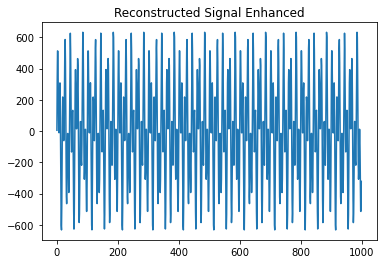

In [242]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pywt



def wavelet_packet_decomposition(signal):
    # perform wavelet packet decomposition with 'db4' mother wavelet
    wp = pywt.WaveletPacket(signal, 'db4', mode='symmetric', maxlevel=6)
    
    # create an empty list to store the coefficients at each level
    coeffs = []
    
    # loop over levels 1 through 5 (level 6 is the terminal node, which we skip)
    for level in range(1, 5):
        # get the data from all nodes at the current level
        level_coeffs = [node.data for node in wp.get_level(level, 'natural')]
        # add the coefficients for the current level to the list
        coeffs.append(level_coeffs)
        
        
    # return the coefficients and the wavelet packet object
    return coeffs, wp 


#wp = pywt.WaveletPacket(signal, wavelet, mode='symmetric', maxlevel=6)
#coeffs = pywt.wavedec(signal, 'db4', level=5)  # wavelet decomposition

def fourier_transform(coeffs):
    # perform Fourier Transform on each sub-band
    freq_coeffs = []
    for level in range(len(coeffs)):
        freq_level_coeffs = []
        for i in range(len(coeffs[level])):
            freq_coeffs_i = np.abs(np.fft.fft(coeffs[level][i], n=2048))
            freq_level_coeffs.append(freq_coeffs_i)
        freq_coeffs.append(freq_level_coeffs)
    return freq_coeffs

#print(freq_coeffs, "value")

def logarithmic_enhancement(freq_coeffs):
    # apply logarithmic enhancement function to each frequency spectrum
    enhanced_freq_coeffs = []
    for level in range(len(freq_coeffs)):
        enhanced_level_coeffs = []
        for i in range(len(freq_coeffs[level])):
            enhanced_coeffs_i = np.log(np.abs(freq_coeffs[level][i])+1)
            enhanced_level_coeffs.append(enhanced_coeffs_i)
        enhanced_freq_coeffs.append(enhanced_level_coeffs)
    return enhanced_freq_coeffs

def inverse_fourier_transform(enhanced_freq_coeffs):
    # perform inverse Fourier Transform on each enhanced sub-band
    enhanced_time_coeffs = []
    for level in range(len(enhanced_freq_coeffs)):
        enhanced_level_coeffs = []
        for i in range(len(enhanced_freq_coeffs[level])):
            enhanced_time_coeffs_i = np.fft.ifft(enhanced_freq_coeffs[level][i], n=2048).real
            enhanced_level_coeffs.append(enhanced_time_coeffs_i)
        enhanced_time_coeffs.append(enhanced_level_coeffs)
    return enhanced_time_coeffs

def enhanced_fourier_transform(coeffs, enhanced_time_coeffs, wp):
    # resize the enhanced time coefficients arrays to match the size of the original coefficients arrays
    for level in range(len(enhanced_time_coeffs)):
        for i in range(len(enhanced_time_coeffs[level])):
            n = len(coeffs[level][i]) # get the length of the original coefficient array at this level
            m = len(enhanced_time_coeffs[level][i]) # get the length of the enhanced coefficient array at this level
            if n > m:
                enhanced_time_coeffs[level][i] = pywt.pad(enhanced_time_coeffs[level][i], (0, n-m), 'zero') # pad the enhanced coefficient array with zeros if it's shorter than the original
            elif n < m:
                enhanced_time_coeffs[level][i] = enhanced_time_coeffs[level][i][:n] # truncate the enhanced coefficient array if it's longer than the original

    # combine or fuse the enhanced sub-band signals to reconstruct the signal in time domain
    reconstructed_signal = np.zeros_like(signal) # create a zero-filled array of the same size as the original signal
    for level in range(len(enhanced_time_coeffs)):
        for i in range(len(enhanced_time_coeffs[level])):
            # get the list of nodes at the current level
            nodes = wp.get_level(level+1, 'natural')
            # loop over the nodes and get their paths
            for node in nodes:
                node_path = node.path # get the path of the current node in the wavelet packet tree
                # do something with node_path
                reconstructed_node = wp[node_path].data # save the original data at this node
                wp[node_path].data = enhanced_time_coeffs[level][i] # set the data at this node to the enhanced coefficient array
                reconstructed_signal += wp.reconstruct(update=wp[node_path]) # use the updated wavelet packet tree to reconstruct the signal
                wp[node_path].data = reconstructed_node # reset the data at this node to the original data
    return reconstructed_signal # return the reconstructed signal


def Signal_Noise_Ratio(signal):
    
    # Convert the Signal into a float array.
    data = np.array(signal, dtype=float)
    
    # Calculate the power of the signal.
    signal_power = np.sum(data ** 2) / len(data)
    
    # Convert the reconstructed signal into a float array.
    data_r = np.array(reconstructed_signal, dtype=float)
    
    # Calculate the power of the reconstructed signal
    recontructed_signal_power = np.sum(data_r ** 2) / len(data_r)
    
    # compute the signal to noise ratio
    signal_noise_ratio = 10 * np.log10(np.abs(signal_power) / np.abs(signal_power - recontructed_signal_power))
    
    return signal_noise_ratio
    
def Mean_Square_Error(signal, reconstructed_signal):
    
    # Truncate signals to match length
    min_len = min(len(signal), len(reconstructed_signal))
    signal = signal[:min_len]
    reconstructed_signal = reconstructed_signal[:min_len]
    
    # Calculate the difference between the original and noisy signals
    diff = signal - reconstructed_signal
    
    # Calculate the squared value of the difference
    squared_diff = np.square(diff)
    
    # Calculate the mean of the squared difference
    mean_square_error = np.mean(squared_diff)
    
    return mean_square_error
    
    

# generate input signal
#signal, sr = librosa.load('audio1/voice.wav', sr=None, duration = 0.021)

i_t = 0.001
pt = np.arange(0,1, i_t)

# our signal will be carried two different frequencies

signal = np.sin(2*np.pi*50*pt) + np.sin(2*np.pi*120*pt)
Signal_clean = Signal
# create a random then add to our signal
#signal = signal + 2.5*np.random.randn(len(pt))

# plot input signal
plt.figure()
plt.plot(signal)
plt.title('Input Signal')


# perform wavelet packet decomposition
coeffs, wp = wavelet_packet_decomposition(signal)
# perform Fourier Transform
freq_coeffs = fourier_transform(coeffs)

# apply logarithmic enhancement function
enhanced_freq_coeffs = logarithmic_enhancement(freq_coeffs)



# perform inverse Fourier Transform
enhanced_time_coeffs = inverse_fourier_transform(enhanced_freq_coeffs)

# perform enhanced Fourier Transform
reconstructed_signal_enhanced = enhanced_fourier_transform(coeffs, enhanced_time_coeffs, wp)

# compute the SNR
S_N_R = Signal_Noise_Ratio(signal)

print('S_N_R : {:.2f}'.format(S_N_R))

mse = Mean_Square_Error(signal, reconstructed_signal)
print('MSE: {:.2f}'.format(mse))

# plot reconstructed signal
plt.figure()
plt.plot(reconstructed_signal_enhanced)
plt.title('Reconstructed Signal Enhanced')
plt.show()
#display
